In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.tsa.holtwinters import ExponentialSmoothing

np.random.seed(42)
random.seed(42)

In [2]:
# Data Import
customers_df = pd.read_excel('customers.xlsx')
purchases_df = pd.read_excel('purchases.xlsx')
products_df = pd.read_excel('products.xlsx')
print(customers_df.head())
print(purchases_df.head())
print(products_df.head())

   customer_id customer_signup_date  is_churned
0            1           2021-11-24           0
1            2           2021-02-27           0
2            3           2021-01-13           0
3            4           2021-05-21           0
4            5           2021-05-06           1
  purchase_date  purchase_amount        campaign  customer_id       roi  \
0    2021-06-09             5.64     Summer_Sale          103  1.249816   
1    2021-12-08           166.46     Summer_Sale          436  1.480286   
2    2021-12-29            42.58    Black_Friday          861  1.238656   
3    2020-09-26             8.19  Winter_Special          271  1.342907   
4    2020-12-12            18.66  Winter_Special          107  1.290650   

         cac  customer_retention  campaign_reach  
0  24.483681            0.822725     5778.523833  
1  21.422267            0.721790     8238.355436  
2  26.947698            0.752656     8694.874591  
3  31.049627            0.734745     6266.258743  
4  26.

In [3]:
# Data Validation
print(customers_df.isnull().sum())
print(purchases_df.isnull().sum())
print(products_df.isnull().sum())

print(customers_df.duplicated().sum())
print(purchases_df.duplicated().sum())
print(products_df.duplicated().sum())

customer_id             0
customer_signup_date    0
is_churned              0
dtype: int64
purchase_date         0
purchase_amount       0
campaign              0
customer_id           0
roi                   0
cac                   0
customer_retention    0
campaign_reach        0
dtype: int64
product_id    0
category      0
model         0
dtype: int64
0
0
0


In [4]:
# Data Conversion
customers_df['customer_signup_date'] = pd.to_datetime(customers_df['customer_signup_date'])
purchases_df['purchase_date'] = pd.to_datetime(purchases_df['purchase_date'])
print(customers_df)
print(purchases_df)

     customer_id customer_signup_date  is_churned
0              1           2021-11-24           0
1              2           2021-02-27           0
2              3           2021-01-13           0
3              4           2021-05-21           0
4              5           2021-05-06           1
..           ...                  ...         ...
995          996           2021-05-16           0
996          997           2021-11-17           0
997          998           2021-10-29           0
998          999           2021-12-05           0
999         1000           2021-04-12           0

[1000 rows x 3 columns]
     purchase_date  purchase_amount        campaign  customer_id       roi  \
0       2021-06-09             5.64     Summer_Sale          103  1.249816   
1       2021-12-08           166.46     Summer_Sale          436  1.480286   
2       2021-12-29            42.58    Black_Friday          861  1.238656   
3       2020-09-26             8.19  Winter_Special          27

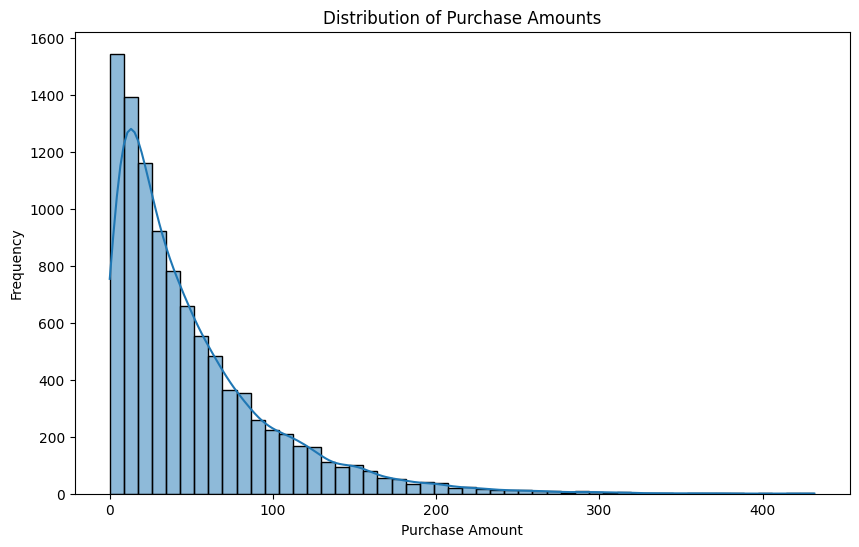

In [5]:
# Data Visualization - Purchase Amount Distribution
plt.figure(figsize=(10, 6))
sns.histplot(purchases_df['purchase_amount'], bins=50, kde=True)
plt.title('Distribution of Purchase Amounts')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()

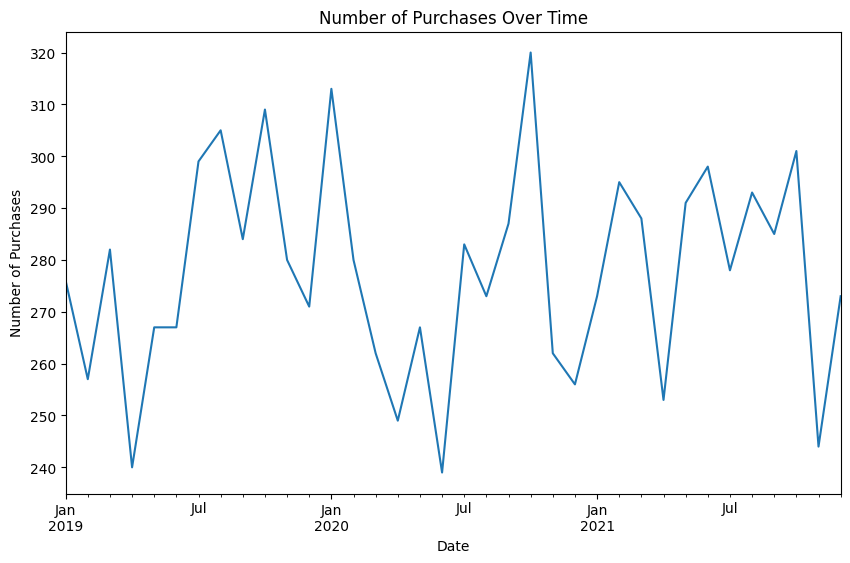

Churn Rate: 20.00%


In [6]:
# Data Visualization - Number of Purchases Over Time
plt.figure(figsize=(10, 6))
purchases_df.set_index('purchase_date').resample('ME')['purchase_amount'].count().plot()
plt.title('Number of Purchases Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.show()

# Churn rate
churn_rate = customers_df['is_churned'].mean()
print(f'Churn Rate: {churn_rate:.2%}')

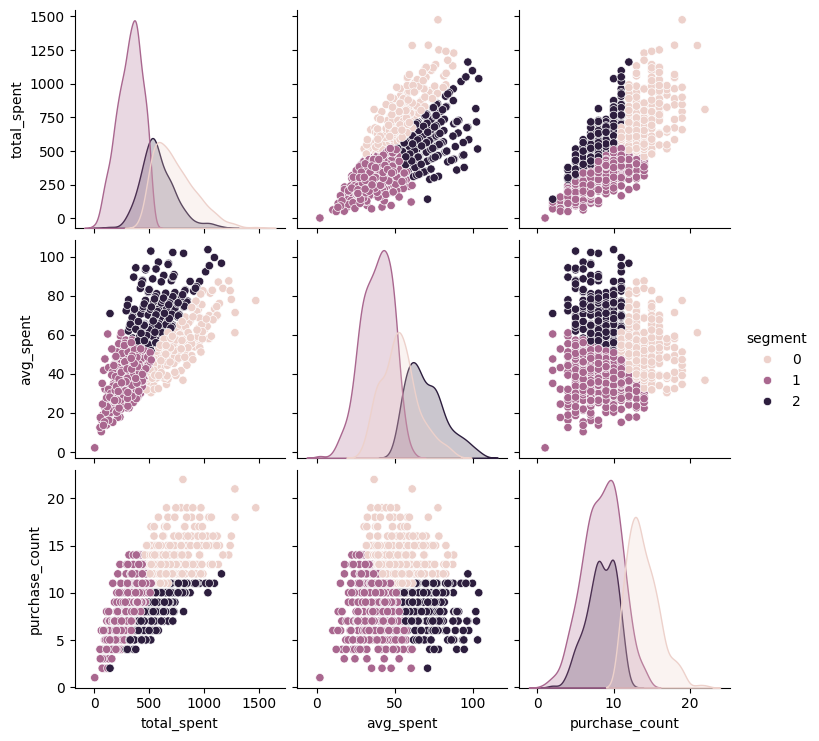

In [7]:
# Customer Segmentation with K-means
if 'customer_id' not in purchases_df.columns:
    num_purchases = len(purchases_df)
    purchase_customer_ids = np.random.choice(customers_df['customer_id'], size=num_purchases)
    purchases_df['customer_id'] = purchase_customer_ids

# Aggregate purchase data by customer
customer_purchase_agg = purchases_df.groupby('customer_id').agg({
    'purchase_amount': ['sum', 'mean', 'count']
}).reset_index()
customer_purchase_agg.columns = ['customer_id', 'total_spent', 'avg_spent', 'purchase_count']

# Merge with customer data
customer_data = pd.merge(customers_df, customer_purchase_agg, on='customer_id', how='left').fillna(0)

# Standardize the data
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['total_spent', 'avg_spent', 'purchase_count']])

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['segment'] = kmeans.fit_predict(customer_data_scaled)

# Visualize the segments
sns.pairplot(customer_data, vars=['total_spent', 'avg_spent', 'purchase_count'], hue='segment')
plt.show()

In [8]:
# Random Forest Model for Churn Prediction
# Prepare the data
X = customer_data[['total_spent', 'avg_spent', 'purchase_count', 'segment']]
y = customer_data['is_churned']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       246
           1       0.23      0.17      0.19        54

    accuracy                           0.75       300
   macro avg       0.53      0.52      0.52       300
weighted avg       0.72      0.75      0.73       300

[[215  31]
 [ 45   9]]


In [9]:
# K-Nearest Neighbors (KNN) Model for Churn Prediction
# Prepare the data
X = customer_data[['total_spent', 'avg_spent', 'purchase_count', 'segment']]
y = customer_data['is_churned']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       246
           1       0.22      0.07      0.11        54

    accuracy                           0.79       300
   macro avg       0.52      0.51      0.49       300
weighted avg       0.71      0.79      0.74       300

[[232  14]
 [ 50   4]]


# Comparison of Classification Algorithms

# K-Nearest Neighbors (KNN)

Overview:
KNN is a simple, instance-based learning algorithm that classifies new data points based on the majority class of the k-nearest neighbors.
It is non-parametric, meaning it does not assume any underlying data distribution.

How it Works:
Calculate the distance (usually Euclidean) between the new data point and all other points in the training dataset.
Select the k-nearest neighbors (the k points closest to the new data point).
The class label of the new data point is determined by the majority class among the k-nearest neighbors.

Advantages:
Simple to understand and implement.
No training phase; it is a lazy learner.
Can handle multi-class classification problems.

Disadvantages:
Computationally expensive during prediction, especially with large datasets.
Performance can degrade with high-dimensional data (the curse of dimensionality).
Sensitive to the choice of k and the distance metric.

Applications:
Pattern recognition.
Image classification.
Recommender systems.


# Naive Bayes

Overview:
Naive Bayes is a probabilistic classifier based on Bayes' theorem.
It assumes independence between the features (hence "naive").
There are different types of Naive Bayes classifiers: Gaussian, Multinomial, and Bernoulli.

How it Works:
Calculate the prior probability for each class.
Calculate the likelihood of each feature given each class.
Apply Bayes' theorem to compute the posterior probability for each class.
Assign the class with the highest posterior probability to the new data point.

Advantages:
Fast and efficient, both in terms of training and prediction.
Performs well with high-dimensional data.
Robust to irrelevant features.

Disadvantages:
The assumption of feature independence is often unrealistic in real-world scenarios.
Can struggle with small datasets where the independence assumption leads to poor estimates.

Applications:
Text classification (spam detection, sentiment analysis).
Document categorization.
Medical diagnosis.

# Random Forest

Overview:
Random Forest is an ensemble learning method that combines multiple decision trees to improve classification performance.
Each tree is built on a subset of the data and a subset of the features.

How it Works:
Generate multiple bootstrap samples from the original dataset.
For each sample, grow a decision tree using a random subset of features at each split.
Aggregate the predictions from all trees (majority vote for classification, average for regression).

Advantages:
Reduces the risk of overfitting compared to individual decision trees.
Can handle large datasets and high-dimensional data.
Provides feature importance, which can be useful for feature selection.

Disadvantages:
Can be computationally intensive, both in terms of memory and processing power.
Less interpretable compared to a single decision tree.

Applications:
Financial market prediction.
Healthcare (predicting patient outcomes).
Fraud detection.

# Summary
K-Nearest Neighbors (KNN):
Strengths: Simple, no training phase.
Weaknesses: Slow prediction, sensitive to choice of k and distance metric.

Naive Bayes:
Strengths: Fast, handles high-dimensional data well.
Weaknesses: Assumes feature independence, which may not hold in practice.

Random Forest:
Strengths: Reduces overfitting, handles large datasets and high-dimensional data, provides feature importance.
Weaknesses: Computationally intensive, less interpretable.

# Conclusion
Choosing the right classifier depends on the specific problem, dataset size, dimensionality, and the need for interpretability. Each algorithm has its own strengths and weaknesses, and understanding these can help in selecting the most appropriate one for a given task.

# Churn Prediction Analysis Report

Date: June 5, 2024



## Introduction

This report provides an analysis of customer churn using two predictive models: Random Forest and K-Nearest Neighbors (KNN). The objective is to evaluate the performance of these models in predicting customer churn and to offer actionable insights and recommendations for mitigating churn based on the analysis.

## Data and Methods

### Data Sources
- Customers Data: Customer information including signup dates and churn status, imported from `customers.xlsx`.
- Purchases Data: Records of customer purchases, including purchase amounts and dates, imported from `purchases.xlsx`.
- Products Data: Information about products available for purchase, imported from `products.xlsx`.

### Methodology

1. Data Preparation:
   - Imported and cleaned data from Excel files.
   - Aggregated purchase data by customer to calculate total spending, average spending, and purchase counts.
   - Standardized the aggregated data for clustering.
   - Applied K-means clustering to segment customers into different groups based on their purchase behavior.

2. Churn Prediction Models:
   - Random Forest Model: Trained on customer purchase behavior and segment data to predict churn.
   - K-Nearest Neighbors (KNN) Model: Trained on the same data to provide a comparative analysis.

## Model Evaluation

### Random Forest Model

```
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       246
           1       0.23      0.17      0.19        54

    accuracy                           0.75       300
   macro avg       0.53      0.52      0.52       300
weighted avg       0.72      0.75      0.73       300

Confusion Matrix:
[[215  31]
 [ 45   9]]
```

### K-Nearest Neighbors (KNN) Model

```
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       246
           1       0.22      0.07      0.11        54

    accuracy                           0.79       300
   macro avg       0.52      0.51      0.49       300
weighted avg       0.71      0.79      0.74       300

Confusion Matrix:
[[232  14]
 [ 50   4]]
```

### Model Comparison and Insights

- Overall Accuracy: The KNN model has a higher overall accuracy (79%) compared to the Random Forest model (75%).
- Precision and Recall for Churned Customers: Both models have low precision and recall for the churned class (class 1). The Random Forest model has a recall of 17% for churned customers, which is slightly higher than the KNN model's 7%.
- Weighted Averages: Both models show similar weighted average precision, recall, and F1-scores, with the Random Forest model having a slightly better F1-score.

Despite the overall performance, the Random Forest model's higher recall for the churned class makes it more suitable for identifying actual churners, which is crucial for targeted retention efforts.

## Key Findings

1. Customer Segments:
   - Low Spend, High Churn: Customers with lower spending and infrequent purchases are more likely to churn.
   - High Spend, Low Churn: Customers with higher spending and frequent purchases are less likely to churn.

2. Churn Rate: The overall churn rate provides a metric for understanding the scale of the churn problem.

3. Customer Profiles: Profiles of at-risk customers can be used to tailor retention strategies effectively.

## Recommendations

### Targeted Retention Campaigns

1. Personalized Offers: Create personalized offers and discounts for at-risk customers identified by the model.
2. Loyalty Programs: Implement or enhance loyalty programs to incentivize repeat purchases among high-risk segments.

### Customer Feedback and Engagement

1. Surveys and Feedback: Conduct surveys to understand the reasons behind churn and address common issues.
2. Engagement Initiatives: Increase customer engagement through regular communication, newsletters, and updates on new products or services.

### Product and Service Improvements

1. Quality Enhancement: Use customer feedback to identify and fix pain points in the product or service.
2. Feature Development: Develop new features or services that address customer needs and preferences.

### Monitoring and Analysis

1. Continuous Monitoring: Implement continuous monitoring of customer behavior and churn rates.
2. Model Retraining: Regularly retrain the churn prediction model with new data to improve its accuracy and effectiveness.

### Segmentation and Targeting

1. Advanced Segmentation: Use the clustering results to segment customers more effectively and tailor marketing strategies accordingly.
2. Cross-Sell and Upsell: Identify opportunities for cross-selling and upselling to customers based on their purchase history and behavior.

## Conclusion

The analysis indicates that the Random Forest model performs slightly better in identifying churned customers.
By leveraging the insights provided by the model, the company can implement targeted strategies to reduce churn,
enhance customer satisfaction, and improve overall retention rates. Regular monitoring and updates to the model
will ensure its continued relevance and effectiveness in addressing the churn problem.

---

Prepared by:  
[Oguaka Onyebuchi Augustine]  
Machine Learning Developer/Budding Machine Learning Engineer

Contact:  
[augustinebuchi45@gmail.com]  
[+2348143546282]

In [10]:
# Import Campaign Data for campaign analysis
# Import purchase data from Excel file
purchases_df = pd.read_excel('purchases.xlsx')

# Import campaign performance data from Excel file
campaign_performance = pd.read_excel('campaign_performance.xlsx')

# Display the data
print(purchases_df.head())
print(campaign_performance.head())

  purchase_date  purchase_amount        campaign  customer_id       roi  \
0    2021-06-09             5.64     Summer_Sale          103  1.249816   
1    2021-12-08           166.46     Summer_Sale          436  1.480286   
2    2021-12-29            42.58    Black_Friday          861  1.238656   
3    2020-09-26             8.19  Winter_Special          271  1.342907   
4    2020-12-12            18.66  Winter_Special          107  1.290650   

         cac  customer_retention  campaign_reach  
0  24.483681            0.822725     5778.523833  
1  21.422267            0.721790     8238.355436  
2  26.947698            0.752656     8694.874591  
3  31.049627            0.734745     6266.258743  
4  26.280172            0.728749     7036.929893  
         campaign  purchase_amount       roi        cac  customer_retention  \
0    Black_Friday        49.763612  1.296229  27.593534            0.775900   
1    Cyber_Monday        50.822650  1.298587  27.527852            0.776187   
2     

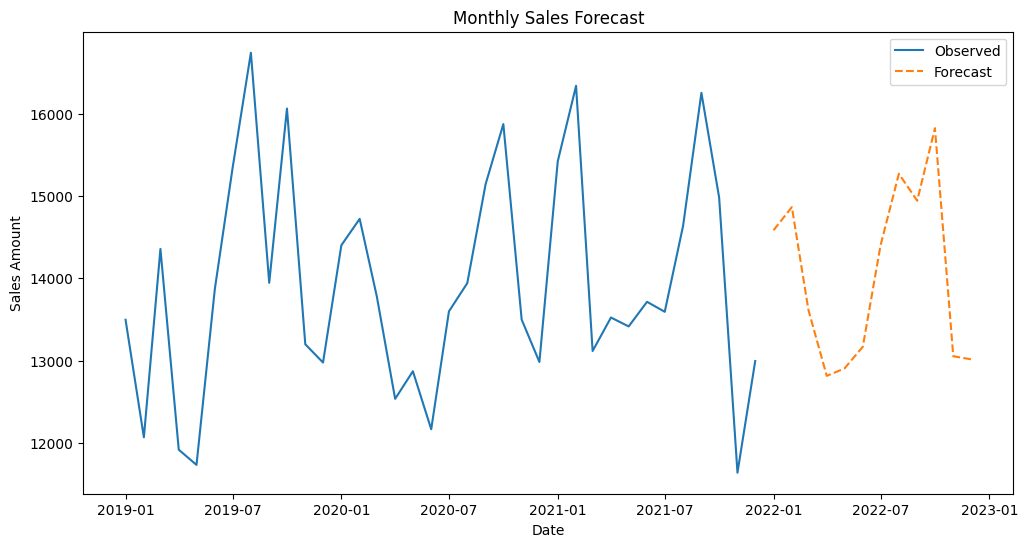

In [11]:
# Section 11: Sales Forecasting
monthly_sales = purchases_df.set_index('purchase_date').resample('MS')['purchase_amount'].sum()

# To ensure that we have at least 24 months of data
if len(monthly_sales) < 24:
    raise ValueError("Not enough data to fit the model. Please ensure you have at least 24 months of data.")

# Fit the Exponential Smoothing model
model = ExponentialSmoothing(monthly_sales, trend='add', seasonal='add', seasonal_periods=12).fit()

# Forecast future sales
forecast = model.forecast(12)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales, label='Observed')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('Monthly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()

In [12]:
# Section 8: Sales Forecasting and Campaign Performance Analysis
# Generate random campaigns
campaigns = ['Summer_Sale', 'Winter_Special', 'Black_Friday', 'Cyber_Monday']
purchase_campaigns = [random.choice(campaigns) for _ in range(len(purchases_df))]
purchases_df['campaign'] = purchase_campaigns

# Generate campaign performance metrics
roi = {campaign: np.random.uniform(1.1, 1.5, len(purchases_df)) for campaign in campaigns}
cac = {campaign: np.random.uniform(20, 35, len(purchases_df)) for campaign in campaigns}
customer_retention = {campaign: np.random.uniform(0.7, 0.85, len(purchases_df)) for campaign in campaigns}
campaign_reach = {campaign: np.random.uniform(5000, 11000, len(purchases_df)) for campaign in campaigns}

purchases_df['roi'] = [roi[campaign][i] for i, campaign in enumerate(purchase_campaigns)]
purchases_df['cac'] = [cac[campaign][i] for i, campaign in enumerate(purchase_campaigns)]
purchases_df['customer_retention'] = [customer_retention[campaign][i] for i, campaign in enumerate(purchase_campaigns)]
purchases_df['campaign_reach'] = [campaign_reach[campaign][i] for i, campaign in enumerate(purchase_campaigns)]

# Save purchase data to an Excel file
purchases_df.to_excel('purchases.xlsx', index=False)

print("Purchase data saved to Excel file successfully.")

# Calculate average metrics by campaign
campaign_metrics = purchases_df.groupby('campaign').agg({
    'purchase_amount': 'mean',
    'roi': 'mean',
    'cac': 'mean',
    'customer_retention': 'mean',
    'campaign_reach': 'mean'
}).reset_index()

# Save campaign performance data to an Excel file
campaign_metrics.to_excel('campaign_performance.xlsx', index=False)

print("Campaign performance data saved to Excel file successfully.")
print(campaign_metrics)

Purchase data saved to Excel file successfully.
Campaign performance data saved to Excel file successfully.
         campaign  purchase_amount       roi        cac  customer_retention  \
0    Black_Friday        49.763612  1.296229  27.593534            0.775900   
1    Cyber_Monday        50.822650  1.298587  27.527852            0.776187   
2     Summer_Sale        50.837588  1.298333  27.459223            0.775108   
3  Winter_Special        48.874556  1.301294  27.537779            0.773977   

   campaign_reach  
0     8017.162601  
1     8065.992454  
2     7894.648391  
3     7998.800102  


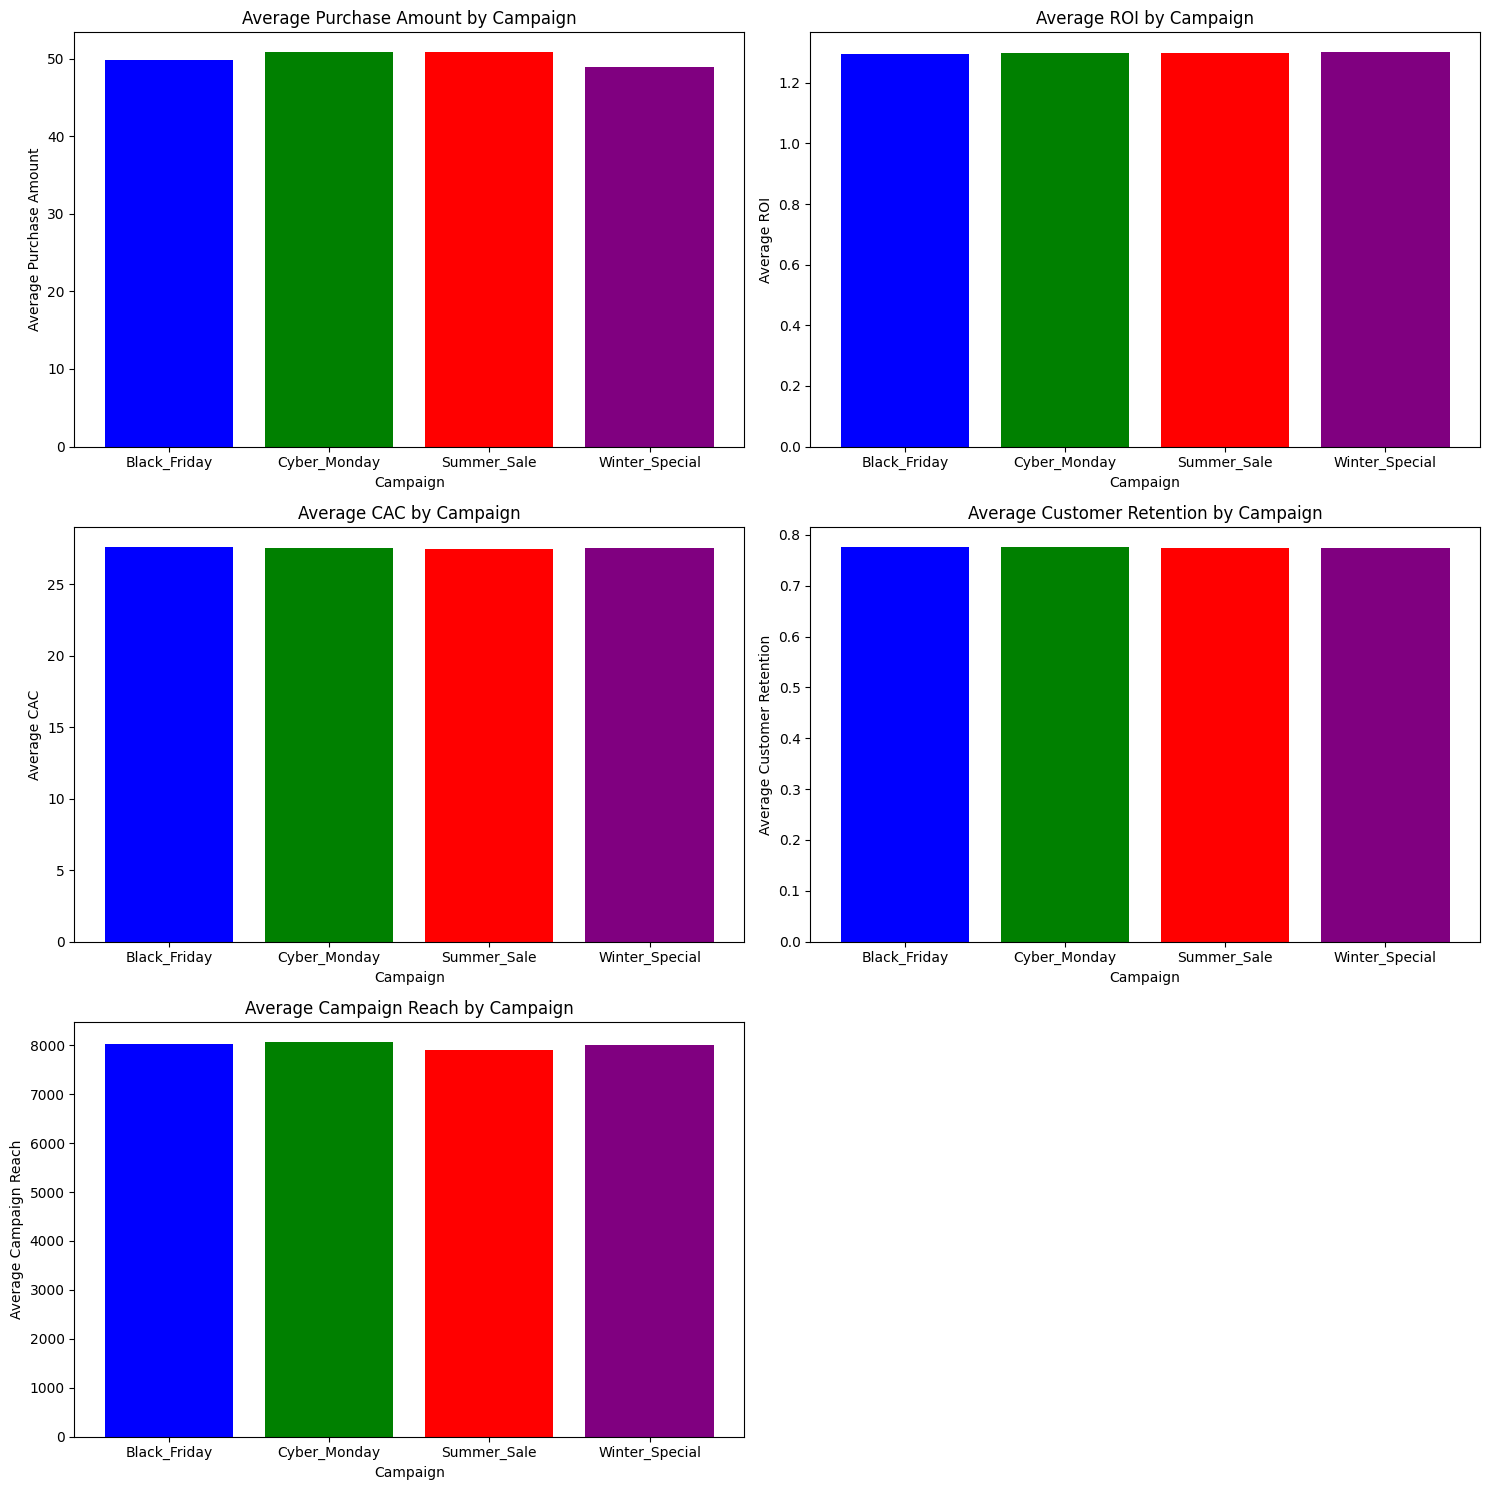

In [13]:
# Section 9: Plot Campaign Performance
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

axes[0, 0].bar(campaign_metrics['campaign'], campaign_metrics['purchase_amount'], color=['blue', 'green', 'red', 'purple'])
axes[0, 0].set_title('Average Purchase Amount by Campaign')
axes[0, 0].set_xlabel('Campaign')
axes[0, 0].set_ylabel('Average Purchase Amount')

axes[0, 1].bar(campaign_metrics['campaign'], campaign_metrics['roi'], color=['blue', 'green', 'red', 'purple'])
axes[0, 1].set_title('Average ROI by Campaign')
axes[0, 1].set_xlabel('Campaign')
axes[0, 1].set_ylabel('Average ROI')

axes[1, 0].bar(campaign_metrics['campaign'], campaign_metrics['cac'], color=['blue', 'green', 'red', 'purple'])
axes[1, 0].set_title('Average CAC by Campaign')
axes[1, 0].set_xlabel('Campaign')
axes[1, 0].set_ylabel('Average CAC')

axes[1, 1].bar(campaign_metrics['campaign'], campaign_metrics['customer_retention'], color=['blue', 'green', 'red', 'purple'])
axes[1, 1].set_title('Average Customer Retention by Campaign')
axes[1, 1].set_xlabel('Campaign')
axes[1, 1].set_ylabel('Average Customer Retention')

axes[2, 0].bar(campaign_metrics['campaign'], campaign_metrics['campaign_reach'], color=['blue', 'green', 'red', 'purple'])
axes[2, 0].set_title('Average Campaign Reach by Campaign')
axes[2, 0].set_xlabel('Campaign')
axes[2, 0].set_ylabel('Average Campaign Reach')

# Remove the empty subplot
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()